In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import requests
import os
from IPython.display import display

In [2]:
raw = pd.read_csv('./DJIA_table.csv')

In [3]:
raw.head(5)

,Date,Open,High,Low,Close,Volume,Adj Close
0,2016-07-01,17924.240234,18002.380859,17916.910156,17949.369141,82160000,17949.369141
1,2016-06-30,17712.759766,17930.609375,17711.800781,17929.990234,133030000,17929.990234
2,2016-06-29,17456.019531,17704.509766,17456.019531,17694.679688,106380000,17694.679688
3,2016-06-28,17190.509766,17409.720703,17190.509766,17409.720703,112190000,17409.720703
4,2016-06-27,17355.210938,17355.210938,17063.080078,17140.240234,138740000,17140.240234


In [4]:
raw_x = raw.drop(columns={'Date', 'Close'})
raw_y_open = raw[['Open']]
raw_y_close = raw[['Adj Close']]
display(raw_x.head(2))
display(raw_y_open.head(2))
display(raw_y_close.head(2))

,Open,High,Low,Volume,Adj Close
0,17924.240234,18002.380859,17916.910156,82160000,17949.369141
1,17712.759766,17930.609375,17711.800781,133030000,17929.990234


,Open
0,17924.240234
1,17712.759766


,Adj Close
0,17949.369141
1,17929.990234


In [6]:
# Data set preprocessing
time_step = 60
total_days = len(raw_y_open)
raw_x = raw_x.values
raw_y_open = raw_y_open.values
raw_y_close = raw_y_close.values

x = []
y_open = []
y_close = []

for i in range(time_step, total_days):
  x.append(raw_x[i-60:i])
  y_open.append(raw_y_open[i])
  y_close.append(raw_y_close[i])

x = np.array(x)
y_open = np.array(y_open)
y_close = np.array(y_close)

print(x.shape, y_open.shape, y_close.shape)

(1929, 60, 5) (1929, 1) (1929, 1)


In [7]:
def split_test(array, spilt_day):
    
    train = array[:-spilt_day, :]
    test = array[-spilt_day:, :]
    
    return train, test

In [8]:
split_day = 30
x_train, x_test = split_test(x, split_day)
y_open_train, y_open_test = split_test(y_open, split_day)
y_close_train, y_close_test = split_test(y_close, split_day)

print(x_train.shape, x_test.shape, y_open_train.shape, y_open_test.shape, y_close_train.shape, y_close_test.shape)

(1899, 60, 5) (30, 60, 5) (1899, 1) (30, 1) (1899, 1) (30, 1)


In [9]:
# Model definition

# Hyperparameters
dropout_rate = 0.5
learning_rate = 0.0001

open_price_inputs = tf.keras.Input(shape=(1,), name='open_price')
inputs = tf.keras.Input(shape=(60, 5,), name='inputs')
y = tf.keras.layers.LSTM(units=50, return_sequences=True)(inputs)
y = tf.keras.layers.Dropout(dropout_rate)(y)
y = tf.keras.layers.LSTM(units=50, return_sequences=True)(y)
y = tf.keras.layers.Dropout(dropout_rate)(y)
y = tf.keras.layers.LSTM(units=50)(y)
y = tf.keras.layers.Dropout(dropout_rate)(y)
y = tf.keras.layers.Dense(1)(y)
y = tf.keras.layers.Multiply()([y, open_price_inputs])
y = tf.keras.layers.Dense(100)(y)
y = tf.keras.layers.Dropout(dropout_rate)(y)
y = tf.keras.layers.Dense(1)(y)

LSTM_Model = tf.keras.Model(inputs=[inputs, open_price_inputs], outputs=y, name="LSTM_Model")
LSTM_Model.summary()

Model: "LSTM_Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 60, 5)]      0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 60, 50)       11200       inputs[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 60, 50)       0           lstm[0][0]                       
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 60, 50)       20200       dropout[0][0]                    
_________________________________________________________________________________________

In [10]:
def RootMeanSquaredError(y_actual, y_predict):
  mse = tf.keras.losses.MeanSquaredError()
  return tf.sqrt(mse(y_actual, y_predict))

LSTM_Model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [11]:
history = LSTM_Model.fit({'inputs': x_train, 'open_price': y_open_train}, y_close_train, batch_size=16, epochs=50, validation_split=0.1, verbose=1)

Epoch 1/50
107/107 [==============================] - 9s 19ms/step - loss: 113776864.0000 - root_mean_squared_error: 10666.6240 - val_loss: 412989.2500 - val_root_mean_squared_error: 642.6424
Epoch 2/50
107/107 [==============================] - 1s 11ms/step - loss: 40272336.0000 - root_mean_squared_error: 6346.0488 - val_loss: 364978.4688 - val_root_mean_squared_error: 604.1345
Epoch 3/50
107/107 [==============================] - 1s 11ms/step - loss: 30382426.0000 - root_mean_squared_error: 5512.0254 - val_loss: 140159.8125 - val_root_mean_squared_error: 374.3792
Epoch 4/50
107/107 [==============================] - 1s 11ms/step - loss: 26760118.0000 - root_mean_squared_error: 5173.0181 - val_loss: 163824.2812 - val_root_mean_squared_error: 404.7521
Epoch 5/50
107/107 [==============================] - 1s 11ms/step - loss: 23720476.0000 - root_mean_squared_error: 4870.3672 - val_loss: 172451.8281 - val_root_mean_squared_error: 415.2732
Epoch 6/50
107/107 [============================

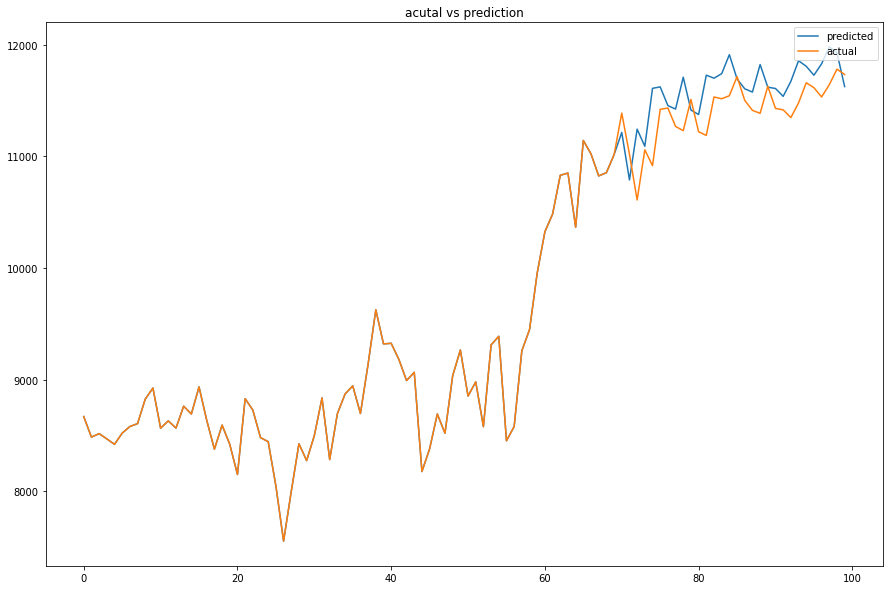

In [12]:
background = raw['Adj Close'].iloc[-100:].to_frame()
background.index = np.arange(100)
predicted_close_price = LSTM_Model.predict([x_test, y_open_test])
predicted_close_price = np.concatenate([background.values[:70], predicted_close_price], axis=0)

# plot acutal vs prediction
plt.figure(figsize=(15,10))
plt.plot(predicted_close_price)
plt.plot(background)
plt.title('acutal vs prediction')
# plt.ylabel('predicted_close_price')
# plt.xlabel('epoch')
plt.legend(['predicted', 'actual'], loc='upper right')
plt.show()

In [14]:
x_test[0].shape

(60, 5)

In [ ]:
# Areas of improvement: (2021-09-02)
# Use more sofisticated architecture/try out new techniques eg. deep RNN, GRU, diminishing learning rate, RMSprop, cross-validation
# Next-30-days prediction (sliding window)